In [1]:
# importing the tools required for the Poisson regression model
import fetch_data
import time
import numpy as np
import pandas as pd
import numpy.random as rnd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson,skellam
import seaborn
import pylab

## Simulating a match by using very simple model 

We can start by setting up basic scoring rates for La Liga 

In [2]:
#Length of match
match_minutes = 90
#Average goals per match (taken from FootyStats)
goals_per_match = 2.65
#Probability of a goal per minute 
prob_per_min = np.array(goals_per_match/match_minutes)
print('The probability of a goal per minute is %5.5f \n' %prob_per_min)

The probability of a goal per minute is 0.02944 



Now we can simulate a single game. The goals go in with the same probability every minute. We will run the simulation 10 times. 

In [3]:
#count for the number of goals
goals=0
for minute in range(match_minutes):
    #Generate a random number between 0 and 1
    r = rnd.rand(1,1)
    #Prints an X when there is a goal and zero otherwise
    if (r < prob_per_min):
        #Goal if the random number is less than the goal probability 
        print('X', end = ' ')
        goals=goals+1
        time.sleep(1) #Longer pause
    else:
        print('o', end= ' ')
        time.sleep(0.1) #Short pause
print('\n')
print('Final whistle. \n \nThere were ' + str(goals) + ' goals.')

o o o X o o o o X o o o o o o o o o o o o o o o o X o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o X o o o o o o o o o o o o o o o o o o 

Final whistle. 
 
There were 4 goals.


## Simulating goals over a season

We will simulate 380 matches of a football season and look at how well it predicts the distribution of the number of goals. We loop over 380 matches, store the number of goals for each match in an array and then make a historgram of the number of goals.

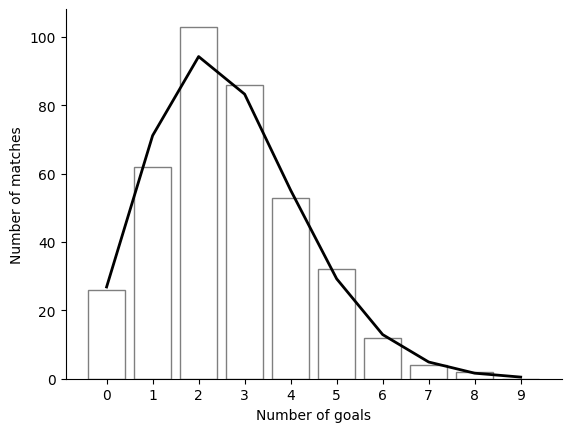

In [4]:
def simulate_match(n, p):
    #n - number of time units
    #p - probability per time unit of a goal

    #count the number of goals
    goals = 0
    for minute in range(n):
        #Generate a random number between 0 and 1
        r = rnd.rand(1,1)
        if (r < p):
            #Goal if the random number is less than the goal probability 
            goals=goals+1
    return goals

#Number of matches
num_matches = 380
#Loop over all the matches
goals = np.zeros(num_matches)
for i in range(num_matches):
    goals[i] = simulate_match(match_minutes, prob_per_min)

#Create the histogram
fig, ax = pylab.subplots(num=1)
histogram_range = np.arange(-0.5, 9.51, 1)
histogram_goals = np.histogram(goals, histogram_range)

ax.bar(histogram_goals[1][:-1] + 0.5, histogram_goals[0], color='white', edgecolor='black', linestyle='-', alpha=0.5)
ax.set_ylim()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0, 10, step=1))
ax.set_yticks(np.arange(0, 101, step=20))
ax.set_xlabel('Number of goals')
ax.set_ylabel('Number of matches')

#Plot the Poisson distribution curve
x = np.arange(0,10)
poisson_dist = poisson.pmf(x, mu=2.65) * num_matches
ax.plot(x, poisson_dist, color='black', linestyle='-', linewidth=2)
pylab.show()


### Probability of scoring

What is interesting about football is the unpredictability. If we look away for a few seconds while watching a match, we could miss an important build-up play leading to a sudden goal. This means that a goal is just as likely to occur at any time during a match. It is important to note that there are all sort of factors determining the rate at which a team scores, but the timing of goals is more or less random. 

The average of 2.65 goals per match, means the probability that there is a goal in any one minute is 2.65/90 = 0.029 (we ignored added-time in the simple model). This means that the chance of us seeing a goal in any randomly chosen minute is about 1 in 34.


### Histogram of goals over a season

The histogram we made shows how often various scorelines would have occured. By running the simulation multiple times, we can see that a pattern starts to appear. The Poisson Distribution essentially translates mean averages into a probability for variable outcomes across a distribution. We made a poisson distribution curve which is the line we can see along the histogram. The single equation, which has only one parameter (the mean number of goals per match of 2.65) captures the whole distribution curve for goals per patch. Obviously, it is not perfect but this is a very important observation. It not only allows us to assign probabilities to match outcomes, but it also allows us (through Poisson regression) to evaluate teams and how various actions contribute to effective football. 

We assumed in the simulation that neither the number of goals scored so far, nor the amount of time played, influences the probability of another goal being scored. We should note that our simple model predictions are obviously not perfect, we can always expect variation between seasons. Our simple model is also based on the very simple assumption that goals are equally likely to occur at any given time point in the match. Therefore, we obviously have model error. The bright side is that a simple model can give us more insights when it is wrong. If we wanted to create a complex model of football betting then the discrepencies we have are important and we would want to change the model assumptions. 

## Improving the model 

In [6]:
#getting the data from Supabase database
laLiga = fetch_data.getMatches()
laLiga = laLiga.rename(columns={'fthg': 'HomeGoals', 'ftag': 'AwayGoals'})
laLiga.head()


,hometeam,awayteam,HomeGoals,AwayGoals
0,Almeria,Vallecano,0,2
1,Sevilla,Valencia,1,2
2,Sociedad,Girona,1,1
3,Las Palmas,Mallorca,1,1
4,Ath Bilbao,Real Madrid,0,2


We have data which contains teams from the 2023/24 La Liga season and the number of goals (Home and Away) scored by each team. 

In [7]:
laLiga.mean(numeric_only=True)

HomeGoals    1.494624
AwayGoals    1.161290
dtype: float64

We can see that on average, the home team scores more goals than the away team. This is what we call 'home field advantage'

### Poisson Distribution

The poisson distribution is a discrete probability distribution that describes the probability of the number of events within a specific time period (90 minutes) with a known average rate of occurance. A key assumption is that the number of events is independent of time. For our example, this means goals don't become more/less likely by the number of goals already scored in the match. Instead, the number of goals is expressed as a function of average rate of goals. Given that we have data for the number of goals scored by the home and away team, we can treat this as two independent poisson distributions. 

The plot below shows the proportion of goals scored compared to the number of goals estimated by the corresponding poisson distributions


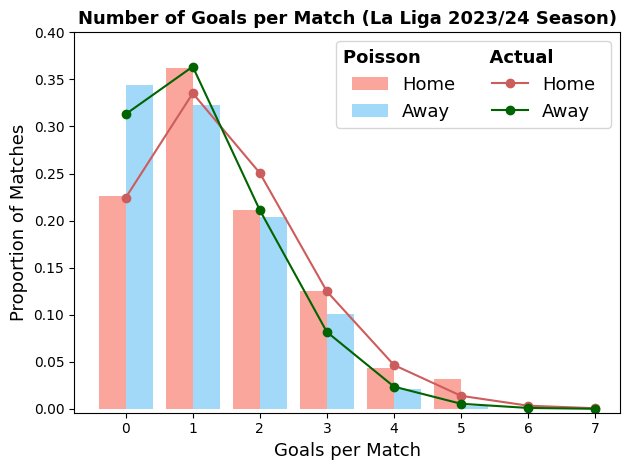

In [8]:
#constructing Poisson distribution for each mean goals value 
poisson_dist = np.column_stack([[poisson.pmf(i, laLiga.mean(numeric_only=True)[j]) for i in range(8)] for j in range(2)])
#plot the histrogram of actual goals
plt.hist(laLiga[['HomeGoals', 'AwayGoals']].values, range(8),
         alpha=0.7, label=['Home', 'Away'], density=True, color=['#FA8072', '#7BC8F6'])
#add lines for the Poisson Distributions
poisson1, = plt.plot([i-0.5 for i in range(1,9)], poisson_dist[:,0],
                     linestyle='-', marker='o', label='Home', color='#CD5C5C')
poisson2, = plt.plot([i-0.5 for i in range(1,9)], poisson_dist[:,1],
                     linestyle='-', marker='o', label='Away', color='#006400')
#set our legend
legend = plt.legend(loc='upper right', fontsize=13, ncol=2)
legend.set_title("Poisson           Actual        ", prop = {'size':'13', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(8)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match (La Liga 2023/24 Season)",size=13,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()

The plot below looks at the distribution of goals scored by FC Barcelona and Atletico Madrid 

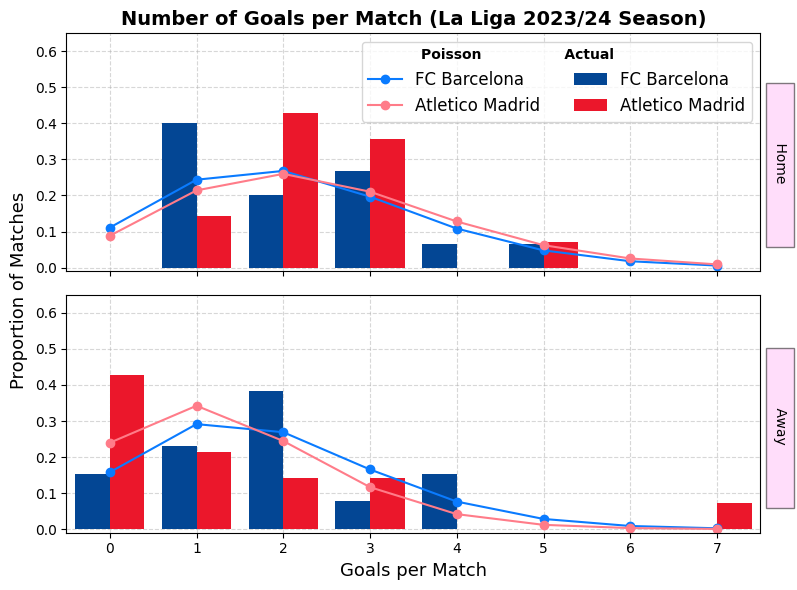

In [10]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(8, 6))
#DataFrame containing the normalized counts of the number of goals scored by FC Barcelona when they played at home
barca_home = laLiga[laLiga['hometeam']=='Barcelona'][['HomeGoals']].apply(pd.value_counts,normalize=True)
#DataFrame containing the normalized counts of the number of goals scored by Atletico Madrid when they played at home
atleti_home = laLiga[laLiga['hometeam']=='Ath Madrid'][['HomeGoals']].apply(pd.value_counts,normalize=True)
#Consructing a list containing the PMF values of the Poisson distribution for the number of goals scored by FC Barcelona at home
barca_home_pois = [poisson.pmf(i,np.sum(np.multiply(barca_home.values.T, barca_home.index.values.T),axis=1)[0]) for i in range(8)]
#Consructing a list containing the PMF values of the Poisson distribution for the number of goals scored by Atletico Madrid at home
atleti_home_pois = [poisson.pmf(i,np.sum(np.multiply(atleti_home.values.T, atleti_home.index.values.T),axis=1)[0]) for i in range(8)]

barca_away = laLiga[laLiga['awayteam']=='Barcelona'][['AwayGoals']].apply(pd.value_counts,normalize=True)
atleti_away = laLiga[laLiga['awayteam']=='Ath Madrid'][['AwayGoals']].apply(pd.value_counts,normalize=True)
#consructing poisson distributions for away goals 
barca_away_pois = [poisson.pmf(i,np.sum(np.multiply(barca_away.values.T, barca_away.index.values.T),axis=1)[0]) for i in range(8)]
atleti_away_pois = [poisson.pmf(i,np.sum(np.multiply(atleti_away.values.T, atleti_away.index.values.T),axis=1)[0]) for i in range(8)]

#setting bar width
bar_width = 0.4

ax1.bar(barca_home.index - bar_width / 2,barca_home.values.reshape(len(barca_home)),width=0.4, color="#034694",label="FC Barcelona")
ax1.bar(atleti_home.index + bar_width / 2,atleti_home.values.reshape(len(atleti_home)),width=0.4, color="#EB172B",label="Atletico Madrid")
#add lines for the Poisson Distributions
poisson1, = ax1.plot([i for i in range(8)], barca_home_pois, linestyle='-', marker='o',label="FC Barcelona", color = "#0a7bff")
poisson1, = ax1.plot([i for i in range(8)], atleti_home_pois, linestyle='-', marker='o',label="Atletico Madrid", color = "#ff7c89")
#Setting up our legend 
leg=ax1.legend(loc='upper right', fontsize=12, ncol=2)
leg.set_title("Poisson                 Actual                ", prop = {'size':'10', 'weight':'bold'})
ax1.set_xlim([-0.5,7.5])
ax1.set_ylim([-0.01,0.65])
ax1.set_xticklabels([])

ax2.bar(barca_away.index - bar_width / 2,barca_away.values.reshape(len(barca_away)),width=0.4, color="#034694",label="FC Barcelona")
ax2.bar(atleti_away.index + bar_width / 2,atleti_away.values.reshape(len(atleti_away)),width=0.4, color="#EB172B",label="Atletico Madrid")
#add lines for the Poisson Distributions
poisson1, = ax2.plot([i for i in range(8)], barca_away_pois, linestyle='-', marker='o',label="FC Barcelona", color = "#0a7bff")
poisson1, = ax2.plot([i for i in range(8)], atleti_away_pois, linestyle='-', marker='o',label="Atletico Madrid", color = "#ff7c89")

ax2.set_xlim([-0.5,7.5])
ax2.set_ylim([-0.01,0.65])
ax1.set_title("Number of Goals per Match (La Liga 2023/24 Season)",size=14,fontweight='bold')
ax2.set_xlabel("Goals per Match",size=13)
ax2.text(-1.15, 0.4, 'Proportion of Matches', rotation=90, size=13)

# Add gridlines to each subplot
ax1.grid(True, linestyle='--', alpha=0.5)
ax2.grid(True, linestyle='--', alpha=0.5)
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)

# mimicing the facet plots in ggplot2 with a bit of a hack
ax1.text(7.65, 0.085,'            Home             ', rotation=-90,
        bbox={'facecolor':'#ffbcf6', 'alpha':0.5, 'pad':5})
ax2.text(7.65, 0.085,'            Away             ', rotation=-90,
        bbox={'facecolor':'#ffbcf6', 'alpha':0.5, 'pad':5})

plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.1)
plt.show()

### Improved Poisson Model 

Now that we can see that the number of goals scored by each team can be roughly approximated by a Poisson Distribution. Its important to note that due to a relatively small sample size (each team plays at most 19 home/away games), the accuracy of the approximation can vary significantly. Now instead of treating each match separately, we will build a more general Poisson Regression Model. In the fit, we include a parameter for home advantage. Team and opponent are fixed effects.

In [11]:
goal_model_data = pd.concat([laLiga[['hometeam', 'awayteam', 'HomeGoals']].assign(home=1).rename(
    columns={'hometeam': 'team', 'awayteam': 'opponent', 'HomeGoals': 'goals'}),
    laLiga[['awayteam', 'hometeam', 'AwayGoals']].assign(home=0).rename(
        columns={'awayteam': 'team', 'hometeam': 'opponent', 'AwayGoals': 'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  558
Model:                            GLM   Df Residuals:                      518
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -770.88
Date:                Mon, 01 Apr 2024   Deviance:                       570.69
Time:                        19:03:28   Pearson chi2:                     494.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2130
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.3310      0.269     -1.230      0.219      -0.858       0.196
team[T.Almeria]             0.1043      0.276      0.377      0.706      -0.437       0.646
team[T.Ath Bilbao]          0.6529      0.244      2.673      0.008       0.174       1.132
team[T.Ath Madrid]          0.7492      0.239      3.130      0.002       0.280       1.218
team[T.Barcelona]           0.7806      0.238      3.282      0.001       0.315       1.247
team[T.Betis]               0.2718      0.262      1.039      0.299      -0.241       0.784
team[T.Cadiz]              -0.2236      0.298     -0.749      0.454      -0.808       0.361
team[T.Celta]               0.1843      0.269      0.686      0.493      -0.342       0.711
team[T.Getafe]              0.3572      0.258      1.384      0.166      -0.149       0.863
team[T.Girona]              0.8625      0.236      3.651      0.000       0.400       1.325
team[T.Granada]             0.2119      0.269      0.789      0.430      -0.315       0.738
team[T.Las Palmas]          0.1301      0.271      0.480      0.631      -0.401       0.661
team[T.Mallorca]           -0.0454      0.284     -0.160      0.873      -0.602       0.511
team[T.Osasuna]             0.2093      0.267      0.784      0.433      -0.314       0.733
team[T.Real Madrid]         0.8331      0.236      3.533      0.000       0.371       1.295
team[T.Sevilla]             0.3558      0.260      1.368      0.171      -0.154       0.866
team[T.Sociedad]            0.4323      0.253      1.711      0.087      -0.063       0.927
team[T.Valencia]            0.2724      0.265      1.029      0.304      -0.247       0.792
team[T.Vallecano]          -0.0419      0.287     -0.146      0.884      -0.605       0.521
team[T.Villarreal]          0.6144      0.247      2.491      0.013       0.131       1.098
opponent[T.Almeria]         0.4736      0.220      2.150      0.032       0.042       0.905
opponent[T.Ath Bilbao]     -0.2316      0.263     -0.881      0.378      -0.747       0.284
opponent[T.Ath Madrid]     -0.0329      0.251     -0.131      0.896      -0.525       0.459
opponent[T.Barcelona]       0.0703      0.246      0.286      0.775      -0.411       0.552
opponent[T.Betis]          -0.0812      0.251     -0.323      0.746      -0.574       0.411
opponent[T.Cadiz]           0.1174      0.239      0.491      0.623      -0.351       0.586
opponent[T.Celta]           0.2208      0.232      0.951      0.342      -0.234       0.676
opponent[T.Getafe]          0.1878      0.234      0.804      0.421      -0.270       0.645
opponent[T.Girona]          0.0148      0.247      0.060      0.952      -0.469       0.499
opponent[T.Granada]         0.5378      0.220      2.450      0.014       0.108       0.968
opponent[T.Las Palmas]     -0.1195      0.251  

### Interpreting our results

We are specifically interested in the values of the coef column, which are analogous to the slopes in linear regression. We also take the exponent of the parameter values. A positive value implies more goals, while values closer to zero represent more neutral effecfs. Towards the bottom we can see that home has a coefficient of 0.2464, which captures the fact that home teams generally score more goals than the away team (specifically 1.28 times more likely in our example). We should note that not all the teams are created equal. For example, Barcelona has a coefficient of 0.78 and Cadiz has a coefficient of -0.22. Which essentially says Barcelona are better scorers than average and Cadiz are much worse scorers than average. The values for opponents penalize and reward teams based on the quality of the opposition. This reflects the defensive strength of each team. For example, Real Madrid has an opponent coefficient of -0.60 which means you're less likely to score against Real Madrid. 

Now we can make some predictions for upcoming matches. We pass our teams into the poisson model and it will return the expected average number of goals for that team. We calculate the expected average number of goals for each team separately. For our specific example, we will see how many goals we expect Atletico Madrid and FC Barcelona to score

In [12]:
predictHome = poisson_model.predict(pd.DataFrame(data={'team': 'Ath Madrid', 'opponent': 'Barcelona', 'home':1},index=[1]))
predictHome

1    2.085398
dtype: float64

In [13]:
predictAway = poisson_model.predict(pd.DataFrame(data={'team': 'Barcelona', 'opponent': 'Ath Madrid', 'home':0},index=[1]))
predictAway

1    1.517037
dtype: float64

Now we can do an example for calculating the probabilties of three outcomes (HomeWin, Draw, AwayWin). We will do this by simulating 10000 matches by having the computer draw random numbers from the two poisson distributions and look at the differences. We get the probabilities for the different outcomes by calculating the proportion of different goal differences. Through the independence assumption, we can simulate the number of goals for each team independently of each other. 

In [14]:
#simulate 10000 matches
np.random.seed(915706074)
nsim = 10000
homeGoalsSim = np.random.poisson(predictHome, nsim)
awayGoalsSim = np.random.poisson(predictAway, nsim)
goalDiffSim = homeGoalsSim - awayGoalsSim
# Home
home_percentage = np.sum(goalDiffSim > 0) / nsim
print("Home:", home_percentage)

# Draw
draw_percentage = np.sum(goalDiffSim == 0) / nsim
print("Draw:", draw_percentage)

# Away
away_percentage = np.sum(goalDiffSim < 0) / nsim
print("Away:", away_percentage)


Home: 0.5012
Draw: 0.217
Away: 0.2818


Now we will do an alternative way of calculating the probability of various events with our two poisson distributions.

In [15]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

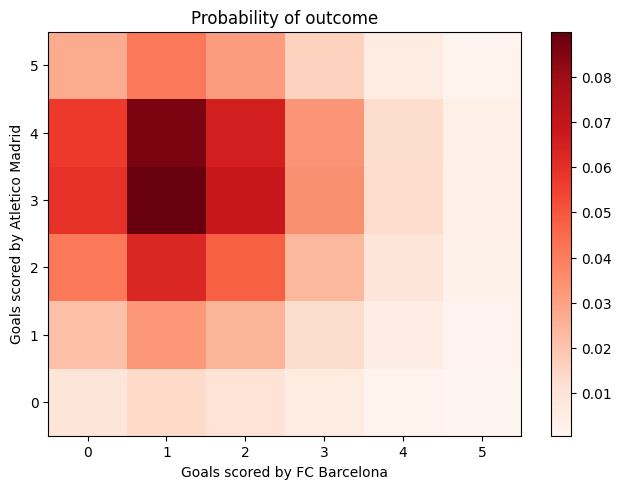

In [16]:
max_goals=5
score_matrix = simulate_match(poisson_model,'Ath Madrid', 'Barcelona', max_goals)
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
pos=ax.imshow(score_matrix, extent=[-0.5,max_goals+0.5,-0.5,max_goals+0.5], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of outcome')
plt.xlim((-0.5,5.5))
plt.ylim((-0.5,5.5))
#plt.xticks(np.arange(0, 4, step=1))
#plt.yticks(np.arange(0, 4, step=1))
plt.tight_layout()
ax.set_xlabel('Goals scored by FC Barcelona')
ax.set_ylabel('Goals scored by Atletico Madrid')
plt.show()


This matrix simply shows the probability of Atletico Madrid (rows of the matrix) and FC Barcelona (matrix columns) scoring a specific number of goals. We then perform some matrix manipulation functions to get the chances of home and away teams winning. In our example Atletico Madrid has around a 48% chance of winning. For fun, we compare this against the odds offered by the bet365 exchange. The odds offered by the exchange had Atletico Madrid at +130 which converted to decimal odds is 43.48%. Our model is very simple and obviously contains some error, but it was not too far off. 

In [17]:
#Home, draw, away probabilities
homewin = np.sum(np.tril(score_matrix, -1))
draw = np.sum(np.diag(score_matrix))
awaywin = np.sum(np.triu(score_matrix, 1))

print('The probability of a home win is ' + str(homewin))
print('The probability of a draw is ' + str(draw))
print('The probability of an away win is ' + str(awaywin))

The probability of a home win is 0.48846508505474584
The probability of a draw is 0.21100417154935905
The probability of an away win is 0.27607605493964693


Overall we built a simple Poisson model to predict results of the Spanish top european division. Despite the flaws it has, it does contain several features that are a necessity for predictive football models. I hope to continue research and find ways of improving this model, as well looking for other models. 